# ChIP-seq and ATAC-seq analysis of E10.5 hindlimbs
#### This Program serves to load various ChIP-seq and ATAC-seq datasets of E10.5 hindlimbs. Eventually, I want to use this to construct a CNN to analyse co-binding of PBX1, HAND2 and CTCF to various genomic loci
### Author: Vera Laub
### Date last modified: 2025-09-24
### status: under construction

In [3]:
# Install packages
import sys
!{sys.executable} -m pip install pyBigWig numpy tensorflow torch matplotlib

# Check if a package is already installed
import importlib.util

package_name = "numpy"
if importlib.util.find_spec(package_name) is None:
    !{sys.executable} -m pip install {package_name}
else:
    print(f"{package_name} is already installed")


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3.12 install --upgrade pip


# Load and open files

In [7]:
# Load libraries
import pyBigWig
import numpy as np
import os
import h5py

In [8]:
# -------------------------------
# 1. File paths
# -------------------------------
# ChIP-seq files
chip_dir = "/Users/veralaub/Documents/postdoc/bioinformatics/data/ChIP-seq/hindlimb"
chip_files = [
    "ChIP-seq_CTCF_E10.5hindlimb_SRX1975283.bw",
    "ChIP-seq_CTCF_E10.5hindlimb_SRX1975284.bw",
    "ChIP-seq_H3K27ac_E10.5hindlimb_SRX14359340.bw",
    "ChIP-seq_H3K27ac_E10.5hindlimb_SRX14359341.bw",
    "ChIP-seq_H3K27me3_E10.5hindlimb_SRX14359342.bw",
    "ChIP-seq_H3K27me3_E10.5hindlimb_SRX14359343.bw",
    "ChIP-seq_HAND2_E10.5hindlimb_SRX14359344.bw",
    "ChIP-seq_HAND2_E10.5hindlimb_SRX14359345.bw",
    "ChIP-seq_PBX1_E10.5hindlimb_SRX14359346.bw",
    "ChIP-seq_PBX1_E10.5hindlimb_SRX14359347.bw"
]
chip_paths = [os.path.join(chip_dir, f) for f in chip_files]

# ATAC-seq files
atac_dir = "/Users/veralaub/Documents/postdoc/bioinformatics/data/ATAC-seq"
atac_files = [
    "ATAC-seq_E10.5hindlimb_rep1_SRX14359357.bw",
    "ATAC-seq_E10.5hindlimb_rep2_SRX14359358.bw",
    "ATAC-seq_E10.5hindlimb_rep3_SRX14359359.bw"
]
atac_paths = [os.path.join(atac_dir, f) for f in atac_files]

# Combine all paths
all_bw_paths = chip_paths + atac_paths

In [9]:
# -------------------------------
# 2. Load bigWig objects
# -------------------------------
bw_list = [pyBigWig.open(p) for p in all_bw_paths]

# Extract information from certain window (Hoxa gene cluster)

In [10]:
# -------------------------------
# 3. Define a function to get a normalized window
# -------------------------------
def get_window(bw, chrom, start, window_size=300):
    vals = bw.values(chrom, start, start + window_size)
    vals = np.nan_to_num(vals)
    # normalize if std != 0
    if np.std(vals) != 0:
        vals = (vals - np.mean(vals)) / np.std(vals)
    return vals

In [46]:
# -------------------------------
# 4. Define chromosomes and window parameters (using chr6 bc this is where Hoxa gene cluster is located)
# -------------------------------
chrom = "chr6"
window_size = 300   # roughly matches peak size in PBX1/CTCF/HAND2 datasets
stride = 150        # 50% overlap so peaks near window edges are captured

# Define a smaller region around Hoxa cluster (adjust as needed)
start_region = 52000000
end_region   = 52500000

In [47]:
# -------------------------------
# 5. Prepare HDF5 file for batch saving
# -------------------------------
output_dir = "/Users/veralaub/Documents/postdoc/bioinformatics/results/CNN_hindlimb/E10.5_ChIP-seq_ATAC-seq"
os.makedirs(output_dir, exist_ok=True)  # create directory if it doesn't exist
output_file = os.path.join(output_dir, "windows_chr6_Hoxa_region.h5")

num_channels = len(bw_list)

with h5py.File(output_file, "w") as f:
    dset = f.create_dataset(
        "X",
        shape=(0, window_size, num_channels),
        maxshape=(None, window_size, num_channels),
        chunks=True,
        dtype='float32'
    )
    
    idx = 0
    for start in range(start_region, end_region - window_size, stride):
        # Extract windows from all bigWigs
        window_channels = [get_window(bw, chrom, start, window_size) for bw in bw_list]
        window_array = np.stack(window_channels, axis=-1)[np.newaxis, ...]  # add window axis
        
        # Resize dataset and save
        dset.resize(idx + 1, axis=0)
        dset[idx] = window_array
        idx += 1

    print(f"Processed {idx} windows and saved to {output_file}")

Processed 3332 windows and saved to /Users/veralaub/Documents/postdoc/bioinformatics/results/CNN_hindlimb/E10.5_ChIP-seq_ATAC-seq/windows_chr6_Hoxa_region.h5


# Inspecting HDF5 file

In [48]:
import h5py

file_path = "/Users/veralaub/Documents/postdoc/bioinformatics/results/CNN_hindlimb/E10.5_ChIP-seq_ATAC-seq/windows_chr6_Hoxa_region.h5"

with h5py.File(file_path, "r") as f:
    # List all datasets in the file
    print("Datasets in file:", list(f.keys()))
    
    # Access the main dataset
    X = f["X"]
    
    # Check its shape
    print("Shape of dataset:", X.shape)
    
    # Check datatype
    print("Data type:", X.dtype)


Datasets in file: ['X']
Shape of dataset: (3332, 300, 13)
Data type: float32


In [49]:
# View a single window
with h5py.File(file_path, "r") as f:
    X = f["X"]
    
    # Get the first window
    first_window = X[0]  # shape: (window_size, num_channels)
    
    print("First window shape:", first_window.shape)
    print("First 10 values of first channel:", first_window[:10, 0])

First window shape: (300, 13)
First 10 values of first channel: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


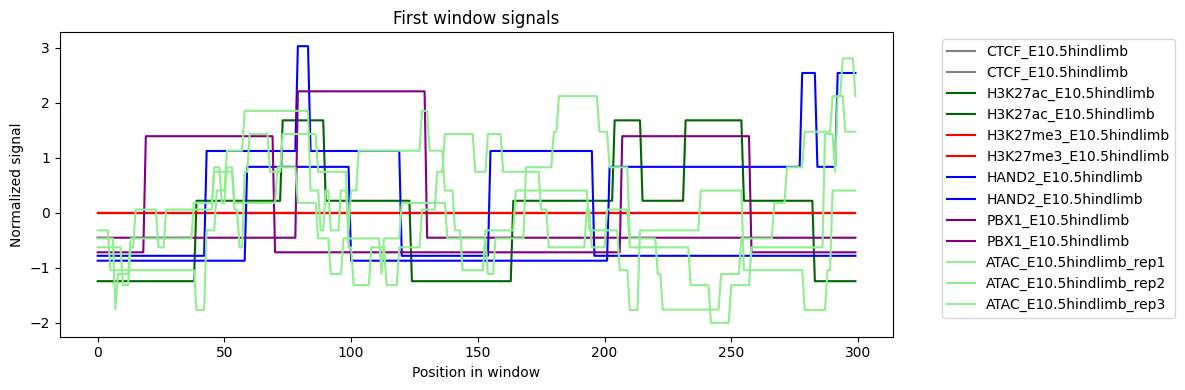

In [50]:
import os
import matplotlib.pyplot as plt
import h5py

# -------------------------------
# Define target keywords
# -------------------------------
targets = ["PBX1", "HAND2", "CTCF", "H3K27ac", "H3K27me3", "ATAC"]

# -------------------------------
# Create descriptive labels and assign targets
# -------------------------------
channel_labels = []
channel_targets = []
for path in all_bw_paths:
    fname = os.path.basename(path)
    
    # Remove prefixes
    if fname.startswith("ChIP-seq_"):
        label = fname.replace("ChIP-seq_", "")
    else:
        label = fname.replace("ATAC-seq_", "ATAC_")
    
    # Remove SRX ID
    label_clean = "_".join(label.split("_")[:-1])
    channel_labels.append(label_clean)
    
    # Determine the target by checking keywords
    found = False
    for t in targets:
        if t in label_clean:
            channel_targets.append(t)
            found = True
            break
    if not found:
        channel_targets.append("Other")  # fallback

# -------------------------------
# Assign manual colors per target
# -------------------------------
color_dict = {
    "PBX1": "purple",
    "HAND2": "blue",
    "CTCF": "grey",
    "H3K27ac": "darkgreen",
    "H3K27me3": "red",
    "ATAC": "lightgreen",
    "Other": "black"  # fallback color
}

channel_colors = [color_dict[t] for t in channel_targets]

# -------------------------------
# Plot the first window
# -------------------------------
with h5py.File(file_path, "r") as f:
    X = f["X"]
    window = X[0]
    
    plt.figure(figsize=(12,4))
    for i in range(window.shape[1]):
        plt.plot(window[:, i], label=channel_labels[i], color=channel_colors[i])
    
    plt.xlabel("Position in window")
    plt.ylabel("Normalized signal")
    plt.title("First window signals")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


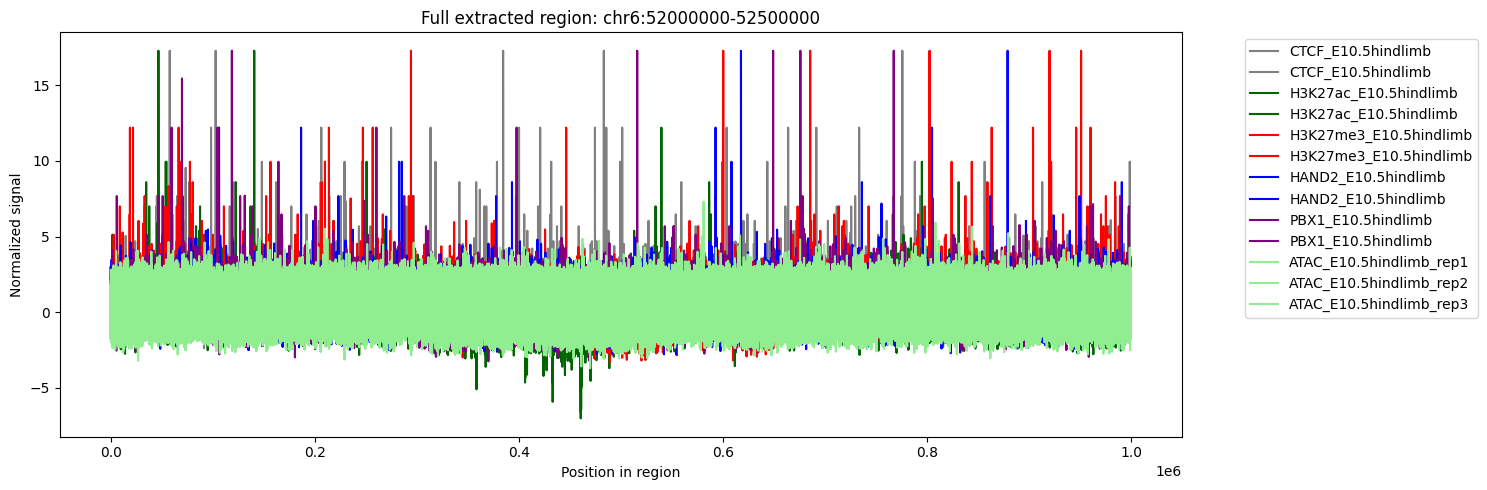

In [51]:
# Visualize for entire Hoxa cluster: Concatenate all windows along the first axis to get a continuous signal for each channel
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Open the HDF5 file
with h5py.File(output_file, "r") as f:
    X = f["X"][:]  # shape: (num_windows, window_size, num_channels)

# Concatenate all windows for each channel to get full region
full_region = np.concatenate([X[i] for i in range(X.shape[0])], axis=0)  # shape: (total_positions, num_channels)

plt.figure(figsize=(15,5))
for i in range(full_region.shape[1]):
    plt.plot(full_region[:, i], label=channel_labels[i], color=channel_colors[i])

plt.xlabel("Position in region")
plt.ylabel("Normalized signal")
plt.title(f"Full extracted region: {chrom}:{start_region}-{end_region}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
